In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from tensorflow.keras import utils 
import numpy as np 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, GRU, MaxPool1D, MaxPool2D, LeakyReLU, Reshape, ReLU
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Concatenate
import os
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Подготовка данных

In [ ]:
gazp = pd.read_csv('/content/drive/MyDrive/Диплом в УИИ/GAZP_150101_210218.csv', sep=';')
gazp.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,60,20150105,110000,129.60,130.94,129.15,129.19,2.451.830
1,GAZP,60,20150105,120000,129.20,132.42,129.16,132.16,3.277.790
2,GAZP,60,20150105,130000,132.06,133.80,131.55,133.71,2.612.150
3,GAZP,60,20150105,140000,133.68,133.84,133.05,133.10,1.806.360
4,GAZP,60,20150105,150000,133.10,133.40,132.77,132.84,1.292.470


In [ ]:
oil = pd.read_csv('/content/drive/MyDrive/Диплом в УИИ/ICE.BRN_150101_210218.csv', sep=',')
oil.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,ICE.BRN,60,20150102,50000,58.02,58.54,58.00,58.07,2.113
1,ICE.BRN,60,20150102,60000,58.07,58.10,57.61,57.80,942.000
2,ICE.BRN,60,20150102,70000,57.78,57.90,57.71,57.89,606.000
3,ICE.BRN,60,20150102,80000,57.87,57.96,57.41,57.46,2.096
4,ICE.BRN,60,20150102,90000,57.46,57.57,57.40,57.57,316.000


In [ ]:
usd = pd.read_csv('/content/drive/MyDrive/Диплом в УИИ/USDCB_150101_210218.csv', sep=',')
usd.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDCB,60,20150101,10000,56.2376,56.2376,56.2376,56.2376,0
1,USDCB,60,20150113,10000,62.7363,62.7363,62.7363,62.7363,0
2,USDCB,60,20150114,10000,64.8425,64.8425,64.8425,64.8425,0
3,USDCB,60,20150115,10000,66.0983,66.0983,66.0983,66.0983,0
4,USDCB,60,20150116,10000,64.8337,64.8337,64.8337,64.8337,0


In [ ]:
data = gazp.merge(oil, on=['<DATE>',	'<TIME>'])

In [ ]:
data.head()

,<TICKER>_x,<PER>_x,<DATE>,<TIME>,<OPEN>_x,<HIGH>_x,<LOW>_x,<CLOSE>_x,<VOL>_x,<TICKER>_y,<PER>_y,<OPEN>_y,<HIGH>_y,<LOW>_y,<CLOSE>_y,<VOL>_y
0,GAZP,60,20150105,110000,129.60,130.94,129.15,129.19,2.451.830,ICE.BRN,60,55.34,55.52,55.25,55.37,1.695
1,GAZP,60,20150105,120000,129.20,132.42,129.16,132.16,3.277.790,ICE.BRN,60,55.38,55.78,55.34,55.48,5.797
2,GAZP,60,20150105,130000,132.06,133.80,131.55,133.71,2.612.150,ICE.BRN,60,55.49,55.84,55.49,55.69,3.607
3,GAZP,60,20150105,140000,133.68,133.84,133.05,133.10,1.806.360,ICE.BRN,60,55.71,55.78,55.16,55.40,5.986
4,GAZP,60,20150105,150000,133.10,133.40,132.77,132.84,1.292.470,ICE.BRN,60,55.40,55.45,54.84,54.87,6.684


In [ ]:
data = data.merge(usd, on=['<DATE>'], how='inner')

In [ ]:
data.head()

,<TICKER>_x,<PER>_x,<DATE>,<TIME>_x,<OPEN>_x,<HIGH>_x,<LOW>_x,<CLOSE>_x,<VOL>_x,<TICKER>_y,<PER>_y,<OPEN>_y,<HIGH>_y,<LOW>_y,<CLOSE>_y,<VOL>_y,<TICKER>,<PER>,<TIME>_y,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,60,20150113,110000,140.20,140.94,139.00,140.81,2.855.600,ICE.BRN,60,45.89,46.00,45.23,45.39,4.156,USDCB,60,10000,62.7363,62.7363,62.7363,62.7363,0
1,GAZP,60,20150113,120000,140.81,142.80,140.78,141.50,6.900.890,ICE.BRN,60,45.39,45.90,45.31,45.86,6.033,USDCB,60,10000,62.7363,62.7363,62.7363,62.7363,0
2,GAZP,60,20150113,130000,141.48,142.22,141.30,141.98,2.133.690,ICE.BRN,60,45.87,46.30,45.47,45.91,7.120,USDCB,60,10000,62.7363,62.7363,62.7363,62.7363,0
3,GAZP,60,20150113,140000,141.98,142.17,141.10,141.62,4.884.800,ICE.BRN,60,45.94,46.59,45.71,45.71,5.530,USDCB,60,10000,62.7363,62.7363,62.7363,62.7363,0
4,GAZP,60,20150113,150000,141.64,142.67,141.59,142.20,2.895.390,ICE.BRN,60,45.73,45.95,45.19,45.83,6.311,USDCB,60,10000,62.7363,62.7363,62.7363,62.7363,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11176 entries, 0 to 11175
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   <TICKER>_x  11176 non-null  object 
 1   <PER>_x     11176 non-null  int64  
 2   <DATE>      11176 non-null  int64  
 3   <TIME>_x    11176 non-null  int64  
 4   <OPEN>_x    11176 non-null  float64
 5   <HIGH>_x    11176 non-null  float64
 6   <LOW>_x     11176 non-null  float64
 7   <CLOSE>_x   11176 non-null  float64
 8   <VOL>_x     11176 non-null  object 
 9   <TICKER>_y  11176 non-null  object 
 10  <PER>_y     11176 non-null  int64  
 11  <OPEN>_y    11176 non-null  float64
 12  <HIGH>_y    11176 non-null  float64
 13  <LOW>_y     11176 non-null  float64
 14  <CLOSE>_y   11176 non-null  float64
 15  <VOL>_y     11176 non-null  float64
 16  <TICKER>    11176 non-null  object 
 17  <PER>       11176 non-null  int64  
 18  <TIME>_y    11176 non-null  int64  
 19  <OPEN>      11176 non-nul

In [ ]:
data = data.drop(data.columns[[0, 1, 3, 5, 6, 9, 10, 12, 13, 16, 17, 18, 20, 21]], axis=1)
data.head()

,<DATE>,<OPEN>_x,<CLOSE>_x,<VOL>_x,<OPEN>_y,<CLOSE>_y,<VOL>_y,<OPEN>,<CLOSE>,<VOL>
0,20150113,140.20,140.81,2.855.600,45.89,45.39,4.156,62.7363,62.7363,0
1,20150113,140.81,141.50,6.900.890,45.39,45.86,6.033,62.7363,62.7363,0
2,20150113,141.48,141.98,2.133.690,45.87,45.91,7.120,62.7363,62.7363,0
3,20150113,141.98,141.62,4.884.800,45.94,45.71,5.530,62.7363,62.7363,0
4,20150113,141.64,142.20,2.895.390,45.73,45.83,6.311,62.7363,62.7363,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11176 entries, 0 to 11175
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   <DATE>     11176 non-null  int64  
 1   <OPEN>_x   11176 non-null  float64
 2   <CLOSE>_x  11176 non-null  float64
 3   <VOL>_x    11176 non-null  object 
 4   <OPEN>_y   11176 non-null  float64
 5   <CLOSE>_y  11176 non-null  float64
 6   <VOL>_y    11176 non-null  float64
 7   <OPEN>     11176 non-null  float64
 8   <CLOSE>    11176 non-null  float64
 9   <VOL>      11176 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 960.4+ KB


In [ ]:
data['<VOL>_x'] = data['<VOL>_x'].apply(lambda x: int(x.replace('.', '')))
data.head()

,<DATE>,<OPEN>_x,<CLOSE>_x,<VOL>_x,<OPEN>_y,<CLOSE>_y,<VOL>_y,<OPEN>,<CLOSE>,<VOL>
0,20150113,140.20,140.81,2855600,45.89,45.39,4.156,62.7363,62.7363,0
1,20150113,140.81,141.50,6900890,45.39,45.86,6.033,62.7363,62.7363,0
2,20150113,141.48,141.98,2133690,45.87,45.91,7.120,62.7363,62.7363,0
3,20150113,141.98,141.62,4884800,45.94,45.71,5.530,62.7363,62.7363,0
4,20150113,141.64,142.20,2895390,45.73,45.83,6.311,62.7363,62.7363,0


In [ ]:
data['month'] = data['<DATE>'].apply(lambda x: (int(str(x)[4:6])))

In [ ]:
data['day'] = data['<DATE>'].apply(lambda x: (int(str(x)[6:])))

In [ ]:
data = data.drop(data.columns[0], axis=1)

In [ ]:
data.head()

,<OPEN>_x,<CLOSE>_x,<VOL>_x,<OPEN>_y,<CLOSE>_y,<VOL>_y,<OPEN>,<CLOSE>,<VOL>,month,day
0,140.20,140.81,2855600,45.89,45.39,4.156,62.7363,62.7363,0,1,13
1,140.81,141.50,6900890,45.39,45.86,6.033,62.7363,62.7363,0,1,13
2,141.48,141.98,2133690,45.87,45.91,7.120,62.7363,62.7363,0,1,13
3,141.98,141.62,4884800,45.94,45.71,5.530,62.7363,62.7363,0,1,13
4,141.64,142.20,2895390,45.73,45.83,6.311,62.7363,62.7363,0,1,13


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11176 entries, 0 to 11175
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   <OPEN>_x   11176 non-null  float64
 1   <CLOSE>_x  11176 non-null  float64
 2   <VOL>_x    11176 non-null  int64  
 3   <OPEN>_y   11176 non-null  float64
 4   <CLOSE>_y  11176 non-null  float64
 5   <VOL>_y    11176 non-null  float64
 6   <OPEN>     11176 non-null  float64
 7   <CLOSE>    11176 non-null  float64
 8   <VOL>      11176 non-null  int64  
 9   month      11176 non-null  int64  
 10  day        11176 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 1.0 MB


In [ ]:
y = np.array(data[data.columns[1]])
x = np.array(data.drop(data.columns[1], axis=1))
print(x.shape)
print(y.shape)

(11176, 10)
(11176,)


In [ ]:
y_trend = []
y_direction = []
for i in range(len(y)-5):
  if i == 0:
    # y.append(np.array([np_data[i, 3], 0, 0]))
    y_trend.append(np.hstack((np.array([0]),  y[i+1:i+5] - y[i:i+4])))
    y_direction.append(np.hstack((np.array([0]),  y[i+1:i+5] - y[i:i+4])) > 0)
  else:
    y_trend.append(y[i:i+5] - y[i-1:i+4])
    y_direction.append((y[i:i+5] - y[i-1:i+4]) > 0)
y_trend = np.array(y_trend)
y_direction = np.array(y_direction)
print(y_trend.shape)
print(y_direction.shape)

(11171, 5)
(11171, 5)


In [ ]:
print()

In [ ]:
x[0:5]

array([[1.40200e+02, 2.85560e+06, 4.58900e+01, 4.53900e+01, 4.15600e+00,
        6.27363e+01, 6.27363e+01, 0.00000e+00, 1.00000e+00, 1.30000e+01],
       [1.40810e+02, 6.90089e+06, 4.53900e+01, 4.58600e+01, 6.03300e+00,
        6.27363e+01, 6.27363e+01, 0.00000e+00, 1.00000e+00, 1.30000e+01],
       [1.41480e+02, 2.13369e+06, 4.58700e+01, 4.59100e+01, 7.12000e+00,
        6.27363e+01, 6.27363e+01, 0.00000e+00, 1.00000e+00, 1.30000e+01],
       [1.41980e+02, 4.88480e+06, 4.59400e+01, 4.57100e+01, 5.53000e+00,
        6.27363e+01, 6.27363e+01, 0.00000e+00, 1.00000e+00, 1.30000e+01],
       [1.41640e+02, 2.89539e+06, 4.57300e+01, 4.58300e+01, 6.31100e+00,
        6.27363e+01, 6.27363e+01, 0.00000e+00, 1.00000e+00, 1.30000e+01]])

In [ ]:
y[0:5]

array([140.81, 141.5 , 141.98, 141.62, 142.2 ])

In [ ]:
y_trend[:5]

array([[ 0.  ,  0.69,  0.48, -0.36,  0.58],
       [ 0.69,  0.48, -0.36,  0.58,  0.35],
       [ 0.48, -0.36,  0.58,  0.35,  0.7 ],
       [-0.36,  0.58,  0.35,  0.7 ,  0.15],
       [ 0.58,  0.35,  0.7 ,  0.15, -0.76]])

In [ ]:
y_direction[:5]

array([[False,  True,  True, False,  True],
       [ True,  True, False,  True,  True],
       [ True, False,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [ True,  True,  True,  True, False]])

In [ ]:
xLen = 63
valLen = 700

trainLen = data.shape[0]-valLen

xTrain,xTest = x[:trainLen], x[trainLen+xLen+2:]

# xScaler = MinMaxScaler(feature_range=(0, 1))
# xScaler.fit(xTrain)
# xTrain = xScaler.transform(xTrain)
# xTest = xScaler.transform(xTest)


yTrain_trend,yTest_trend = y_trend[:trainLen], y_trend[trainLen+xLen+2:]

# yScaler_trand = MinMaxScaler(feature_range=(-1, 1))
# yScaler_trand.fit(yTrain_trend)
# yTrain_trend = yScaler_trand.transform(yTrain_trend)
# yTest_trend = yScaler_trand.transform(yTest_trend)

yTrain,yTest = y[:trainLen], y[trainLen+xLen+2:]

yTrain = yTrain.reshape(-1, 1)
yTest = yTest.reshape(-1, 1)

# yScaler = MinMaxScaler(feature_range=(0, 1))
# yScaler.fit(yTrain)
# yTrain = yScaler.transform(yTrain)
# yTest = yScaler.transform(yTest)

In [ ]:
print(xTrain.shape, xTest.shape)
print(yTrain.shape, yTest.shape)
print(yTrain_trend.shape, yTest_trend.shape)

(10476, 10) (635, 10)
(10476, 1) (635, 1)
(10476, 5) (630, 5)


In [ ]:
x63Train = []
x63Test = []

In [ ]:
for i in range(63, xTrain.shape[0]):
  if i == xTrain.shape:
    x63Train.append(xTrain[i-63:])
  else:
    x63Train.append(xTrain[i-63:i])
x63Train = np.array(x63Train)
print(x63Train.shape)

(10413, 63, 10)


In [ ]:
for i in range(63, xTest.shape[0]):
  if i == xTest.shape:
    x63Test.append(xTest[i-63:])
  else:
    x63Test.append(xTest[i-63:i])
x63Test = np.array(x63Test)
print(x63Test.shape)

(572, 63, 10)


In [ ]:
yTrain = yTrain[63:]
yTest = yTest[63:]
yTrain_trend = yTrain_trend[63:]
yTest_trend = yTest_trend[63:]
yTrain_direction = y_direction[63:trainLen]
yTest_direction = y_direction[trainLen+63+2+xLen:]

In [ ]:
print(x63Train.shape, x63Test.shape)
print(yTrain.shape, yTest.shape)
print(yTrain_trend.shape, yTest_trend.shape)
print(yTrain_direction.shape, yTest_direction.shape)

(10413, 63, 10) (572, 63, 10)
(10413, 1) (572, 1)
(10413, 5) (567, 5)
(10413, 5) (567, 5)


# Предсказание цены

In [ ]:
modelC = Sequential()
modelC.add(GRU(256, return_sequences=True, input_shape=x63Train.shape[1:], recurrent_dropout=0.2))
modelC.add(Dropout(0.4))
modelC.add(GRU(256, recurrent_dropout=0.2))
modelC.add(Dropout(0.4))
modelC.add(Dense(10, activation="linear"))
modelC.add(Dropout(0.25))
modelC.add(Dense(1, activation="linear"))

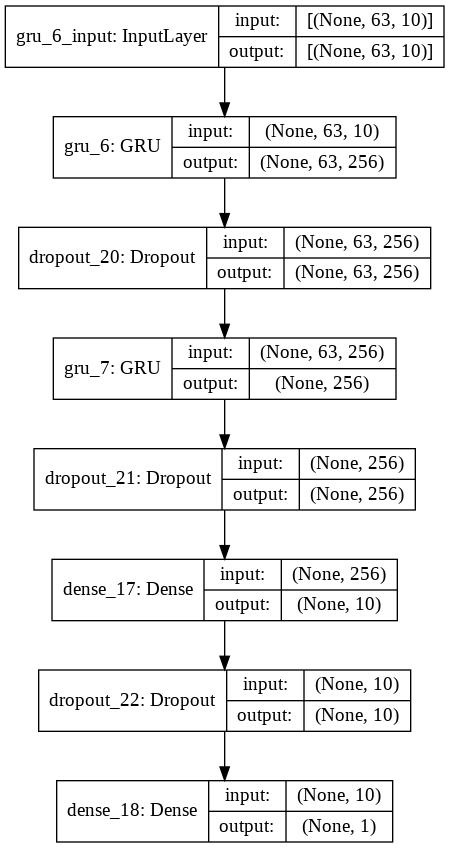

In [ ]:
plot_model(modelC, show_shapes=True)

Epoch 1/25
53/53 [==============================] - 22s 357ms/step - loss: 0.0746 - val_loss: 0.0613
Epoch 2/25
53/53 [==============================] - 19s 364ms/step - loss: 0.0503 - val_loss: 0.0439
Epoch 3/25
53/53 [==============================] - 19s 354ms/step - loss: 0.0403 - val_loss: 0.0264
Epoch 4/25
53/53 [==============================] - 19s 354ms/step - loss: 0.0308 - val_loss: 0.0154
Epoch 5/25
53/53 [==============================] - 19s 364ms/step - loss: 0.0259 - val_loss: 0.0085
Epoch 6/25
53/53 [==============================] - 20s 385ms/step - loss: 0.0239 - val_loss: 0.0052
Epoch 7/25
53/53 [==============================] - 18s 345ms/step - loss: 0.0206 - val_loss: 0.0034
Epoch 8/25
53/53 [==============================] - 19s 360ms/step - loss: 0.0177 - val_loss: 0.0021
Epoch 9/25
53/53 [==============================] - 18s 347ms/step - loss: 0.0170 - val_loss: 0.0025
Epoch 10/25
53/53 [==============================] - 19s 360ms/step - loss: 0.0172 - val_lo

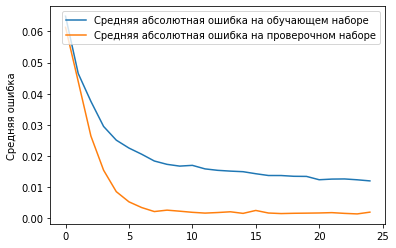

In [ ]:
modelC.compile(loss='mse', optimizer=Adam(lr=1e-5))
history = modelC.fit(x63Train,
                     yTrain,
                     epochs=25,
                     batch_size=200, 
                     verbose=1,
                     validation_data=(x63Test, yTest))
predict = modelC.predict(x63Test)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()


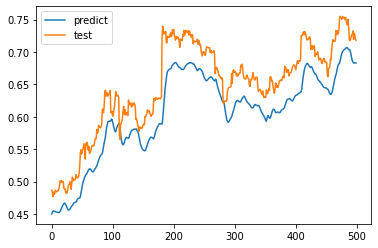

In [ ]:
plt.plot(predict[-500:], label='predict')
plt.plot(yTest[-500:], label='test')
plt.legend()
plt.show()

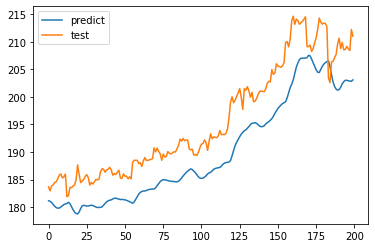

In [ ]:
plt.plot(yScaler.inverse_transform(predict[:200].reshape(-1,1)), label='predict')
plt.plot(yScaler.inverse_transform(yTest[:200].reshape(-1,1)), label='test')
plt.legend()
plt.show()

# Предсказание тренда

In [ ]:
x = Input((63, 9))

c = BatchNormalization()(x)
c = GRU(256, return_sequences=True)(c)
c = Dropout(0.2)(c)
c = GRU(256)(c)
c = Dropout(0.2)(c)
c = Dense(126, activation='relu')(c)
c = Dense(1, activation='relu')(c)

modelTrend = Model(inputs=x, outputs=c)

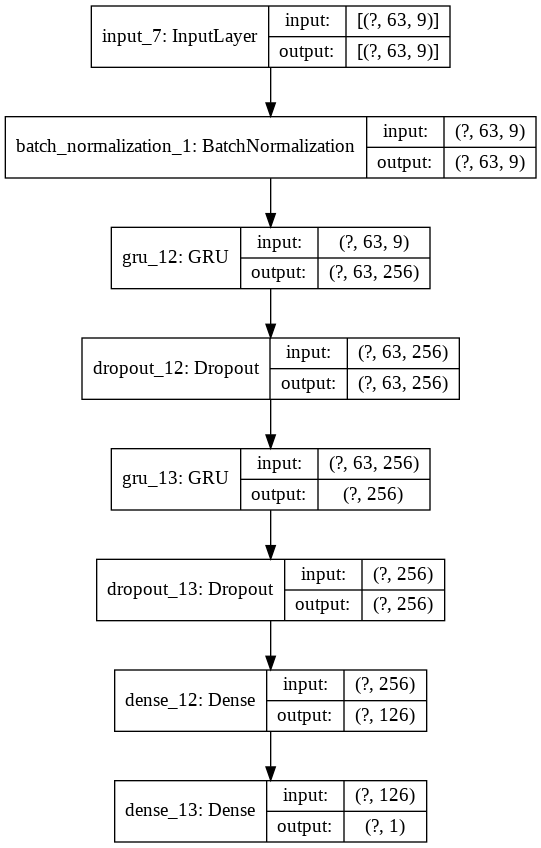

In [ ]:
plot_model(modelTrend, show_shapes=True)

In [ ]:
modelTrend.compile(loss='mse', optimizer=Adam(lr=1e-7))
history = modelTrend.fit(x63Train[:, :,1:],
                     yTrain_trend[:,0],
                     epochs=25,
                     batch_size=200, 
                     verbose=1,
                     validation_data=(x63Test[:-5,:, 1:], yTest_trend[:,0]))
predict = modelTrend.predict(x63Test[:-5,:, 1:])

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Epoch 1/25
53/53 [==============================] - 2s 36ms/step - loss: 0.5935 - val_loss: 0.7331
Epoch 2/25
53/53 [==============================] - 1s 26ms/step - loss: 0.5929 - val_loss: 0.7331
Epoch 3/25
53/53 [==============================] - 1s 25ms/step - loss: 0.5933 - val_loss: 0.7331
Epoch 4/25
53/53 [==============================] - 1s 25ms/step - loss: 0.5930 - val_loss: 0.7331
Epoch 5/25
53/53 [==============================] - 1s 26ms/step - loss: 0.5934 - val_loss: 0.7332
Epoch 6/25
28/53 [==============>...............] - ETA: 0s - loss: 0.6038

KeyboardInterrupt: ignored

In [ ]:
x63Train[:, :,1:]

array([[[2.855600e+06, 4.589000e+01, 4.539000e+01, ..., 0.000000e+00,
         1.000000e+00, 1.300000e+01],
        [6.900890e+06, 4.539000e+01, 4.586000e+01, ..., 0.000000e+00,
         1.000000e+00, 1.300000e+01],
        [2.133690e+06, 4.587000e+01, 4.591000e+01, ..., 0.000000e+00,
         1.000000e+00, 1.300000e+01],
        ...,
        [9.604550e+06, 4.995000e+01, 4.918000e+01, ..., 0.000000e+00,
         1.000000e+00, 2.200000e+01],
        [4.645860e+06, 4.919000e+01, 4.893000e+01, ..., 0.000000e+00,
         1.000000e+00, 2.200000e+01],
        [5.250620e+06, 4.891000e+01, 4.870000e+01, ..., 0.000000e+00,
         1.000000e+00, 2.200000e+01]],

       [[6.900890e+06, 4.539000e+01, 4.586000e+01, ..., 0.000000e+00,
         1.000000e+00, 1.300000e+01],
        [2.133690e+06, 4.587000e+01, 4.591000e+01, ..., 0.000000e+00,
         1.000000e+00, 1.300000e+01],
        [4.884800e+06, 4.594000e+01, 4.571000e+01, ..., 0.000000e+00,
         1.000000e+00, 1.300000e+01],
        ...,


In [ ]:
yTrain_trend.shape

(10413, 5)

In [ ]:
plt.plot(predict[-100:, 1], label='predict')
plt.plot(yTest_trend[-100:, 1], label='test')
plt.legend()
plt.show()

IndexError: ignored

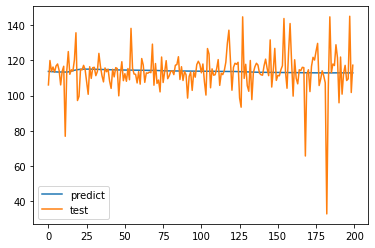

In [ ]:

plt.plot(yScaler.inverse_transform(predict[:200, 1].reshape(-1,1)), label='predict')
plt.plot(yScaler.inverse_transform(yTest_trend[:200, 1].reshape(-1,1)), label='test')
plt.legend()
plt.show()

# Предсказание направления движения

In [ ]:
x = Input((63, 10))
# r = Reshape((-1, 1))(x)
# r = LSTM(20, return_sequences=True)(x)
# r = LSTM(20, return_sequences=True)(r)
r = Conv1D(32, 5, padding='same')(x)
r = LeakyReLU()(r)
r = MaxPool1D(2, padding='same')(r)
r = Dropout(0.2)(r)
r = Conv1D(64, 5, padding='same')(r)
r = LeakyReLU()(r)
r = MaxPool1D(2, padding='same')(r)
r = Dropout(0.2)(r)
# r = Conv1D(128, 5, padding='same')(r)
# r = LeakyReLU()(r)
# r = MaxPool1D(2, padding='same')(r)
# r = Dropout(0.2)(r)
# r = Conv1D(256, 5, padding='same')(r)
# r = LeakyReLU()(r)
# r = MaxPool1D(2, padding='same')(r)
# r = Dropout(0.2)(r)
r = Flatten()(r)
r = Dense(512)(r)
r = LeakyReLU()(r)
r = Dropout(0.2)(r)
r = Dense(1, activation='sigmoid')(r)
modelClass = Model(x, r)

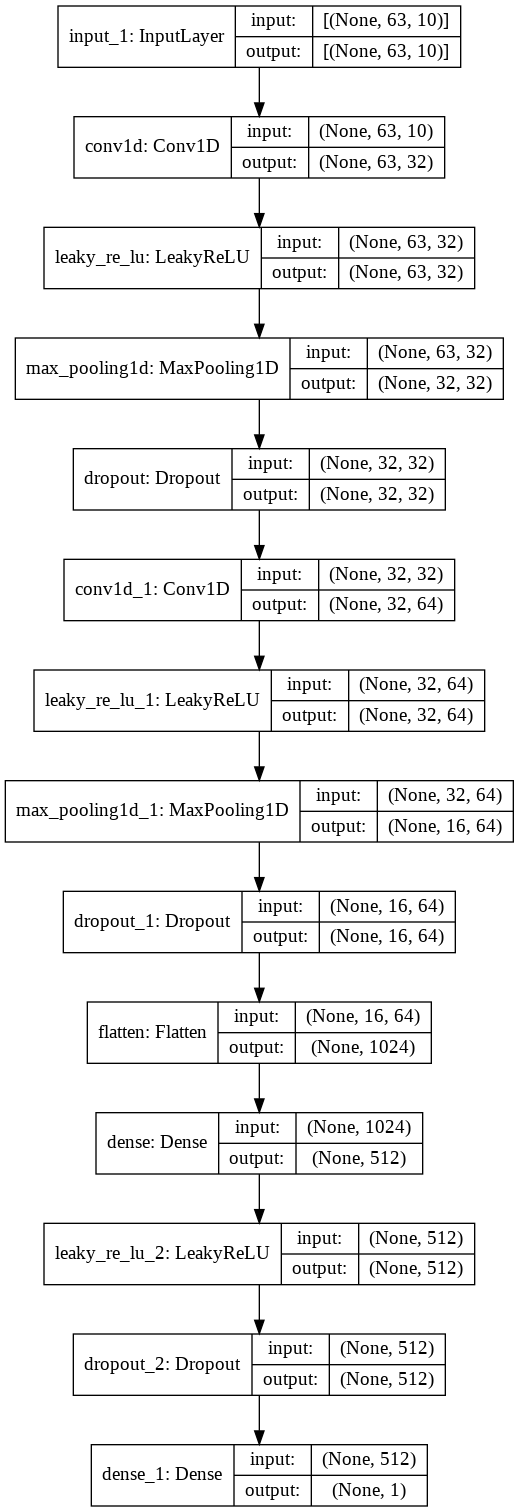

In [ ]:
plot_model(modelClass, show_shapes=True)

Epoch 1/200
53/53 [==============================] - 33s 14ms/step - loss: 0.6963 - val_loss: 0.6940
Epoch 2/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6955 - val_loss: 0.6944
Epoch 3/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6948 - val_loss: 0.6945
Epoch 4/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.6942
Epoch 5/200
53/53 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6947
Epoch 6/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6962 - val_loss: 0.6940
Epoch 7/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6950 - val_loss: 0.6950
Epoch 8/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6934 - val_loss: 0.6939
Epoch 9/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6955 - val_loss: 0.6934
Epoch 10/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.6936
Epoch 1

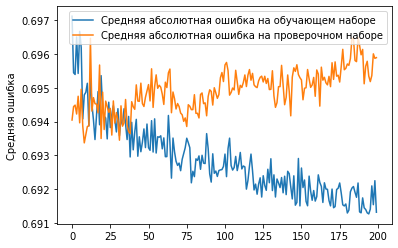

In [ ]:
modelClass.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5))
history = modelClass.fit(x63Train,
                     yTrain_direction[:, 0],
                     epochs=200,
                     batch_size=200, 
                     verbose=1,
                     validation_data=(x63Test[:-5], yTest_direction[:, 0]))
predict = modelClass.predict(x63Test[:-5])

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
plt.plot(predict[-100:, 1], label='predict')
plt.plot(yTest_trend[-100:, 1], label='test')
plt.legend()
plt.show()

NameError: ignored

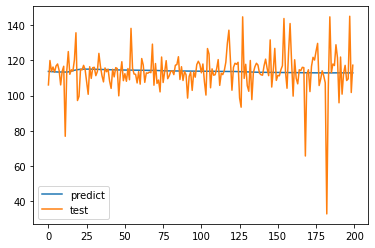

In [ ]:

plt.plot(yScaler.inverse_transform(predict[:200, 1].reshape(-1,1)), label='predict')
plt.plot(yScaler.inverse_transform(yTest_trend[:200, 1].reshape(-1,1)), label='test')
plt.legend()
plt.show()

# Каскад моделей

In [ ]:
x = Input((63, 10))

l = GRU(256, return_sequences=True)(x)
l = LeakyReLU()(l)
l = Dropout(0.2)(l)
l = GRU(256)(l)
l = LeakyReLU()(l)
l = Dropout(0.2)(l)
l = Flatten()(l)
l = Dense(512)(l)
l = LeakyReLU()(l)
l = Dropout(0.2)(l)
l = Dense(1, activation='linear', name='modelL')(l)

c = LSTM(25, return_sequences=True)(x)
c = LeakyReLU()(c)
c = Dropout(0.2)(c)
c = LSTM(25)(c)
c = LeakyReLU()(c)
c = Dropout(0.2)(c)
c = Dense(512)(c)
c = LeakyReLU()(c)
c = Dropout(0.2)(c)
c = Dense(1, activation='linear', name='modelC')(c)

r = LSTM(25, return_sequences=True)(x)
r = LeakyReLU()(r)
r = Dropout(0.2)(r)
r = Conv1D(32, 3, padding='same')(r)
r = LeakyReLU()(r)
r = MaxPool1D(3, padding='same')(r)
r = Dropout(0.2)(r)
r = Flatten()(r)
r = Dense(512)(r)
r = LeakyReLU()(r)
r = Dropout(0.2)(r)
r = Dense(1, activation='linear', name='modelR')(r)
# r = concatenate([l, c, r])

# modelL = Model(inputs=x, outputs=l)
# modelL.compile(loss='mse', optimizer=Adam(lr=1e-5))
# modelC = Model(inputs=x, outputs=c)
# modelC.compile(loss='mse', optimizer=Adam(lr=1e-5))
# modelR = Model(inputs=x, outputs=r)
# modelR.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5))
model = Model(inputs=[x], outputs=[l, c, r])
model.compile(loss={'modelC':'mse', 'modelL':'mse', 'modelR':'binary_crossentropy'}, optimizer=Adam(lr=1e-5))

# y = Input((3, ))
# out = Flatten()(y)
# out = Dense(126, activation='linear')(out)
# out = Dense(1, activation='linear', name='out')(out)
# model = Model(inputs=[y], outputs=[out])
# model.compile(loss='mse', optimizer=Adam(lr=1e-5))

# inp = Input((63, 10))
# final = out1(inp)
# final = model(final)
# result = Model([inp], [final])

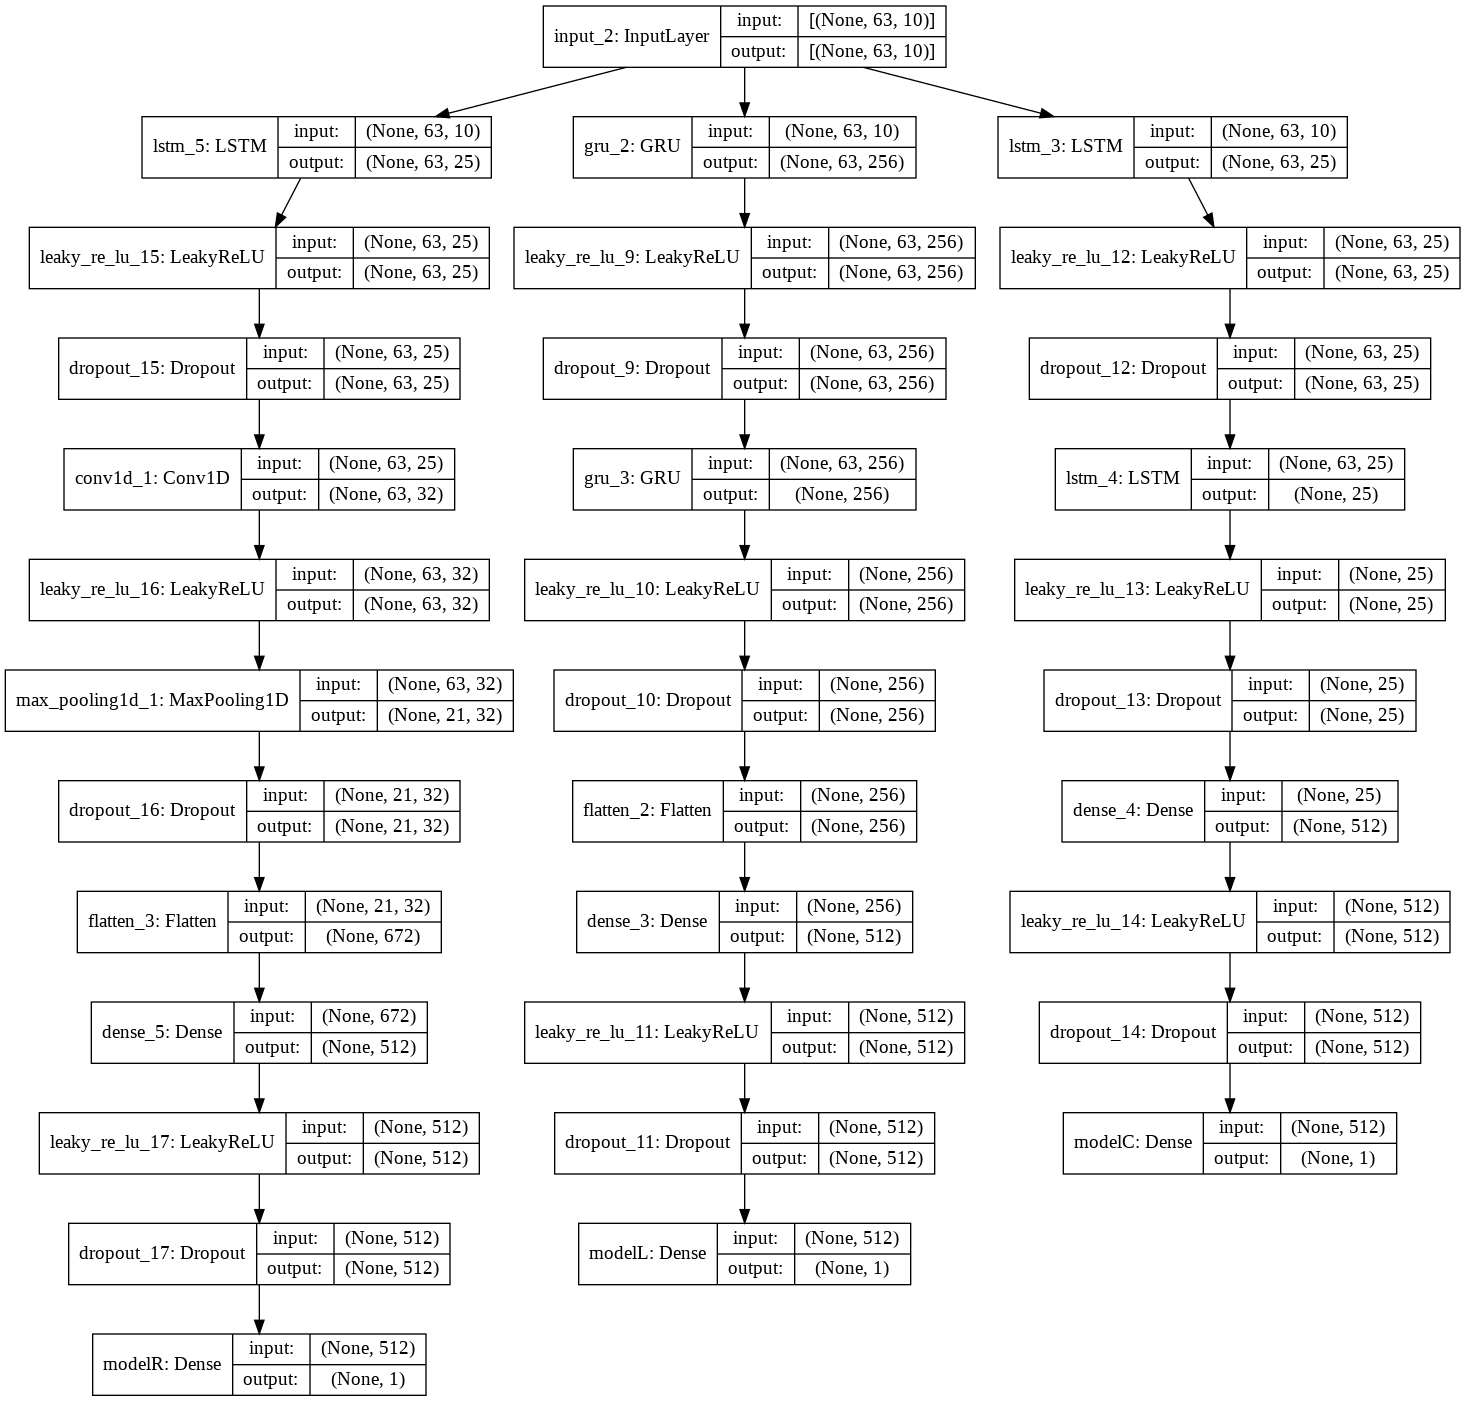

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
yTrain.shape

(10413, 1)

In [ ]:
model.compile(loss=['mse', 'mse', 'mse'], optimizer=Adam(lr=1e-5))
history = model.fit(x63Train,
                     [yTrain, yTrain_trend, yTrain_direction],
                     epochs=50,
                     batch_size=200, 
                     verbose=1,
                     validation_data=(x63Test[:567], [yTest[:567], yTest_trend, yTest_direction]))
predict = model.predict(x63Test)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Epoch 1/50
53/53 [==============================] - 10s 67ms/step - loss: 26684.0603 - modelL_loss: 26682.7352 - modelC_loss: 1.0188 - modelR_loss: 0.3072 - val_loss: 43929.4805 - val_modelL_loss: 43927.4492 - val_modelC_loss: 1.6707 - val_modelR_loss: 0.3641
Epoch 2/50
53/53 [==============================] - 2s 36ms/step - loss: 26373.9222 - modelL_loss: 26372.5939 - modelC_loss: 1.0303 - modelR_loss: 0.2983 - val_loss: 43297.1133 - val_modelL_loss: 43295.0977 - val_modelC_loss: 1.6708 - val_modelR_loss: 0.3454
Epoch 3/50
53/53 [==============================] - 2s 36ms/step - loss: 25580.0329 - modelL_loss: 25578.7360 - modelC_loss: 0.9997 - modelR_loss: 0.2965 - val_loss: 42317.8203 - val_modelL_loss: 42315.8008 - val_modelC_loss: 1.6709 - val_modelR_loss: 0.3475
Epoch 4/50
53/53 [==============================] - 2s 36ms/step - loss: 25052.6565 - modelL_loss: 25051.3940 - modelC_loss: 0.9704 - modelR_loss: 0.2935 - val_loss: 40947.7305 - val_modelL_loss: 40945.7305 - val_modelC_lo

KeyboardInterrupt: ignored

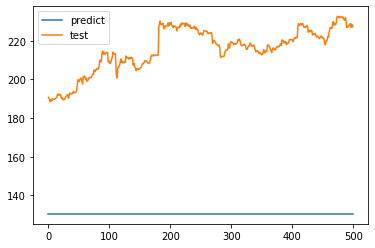

In [ ]:
plt.plot(predict[-500:], label='predict')
plt.plot(xTest[-500:, 0], label='test')
plt.legend()
plt.show()

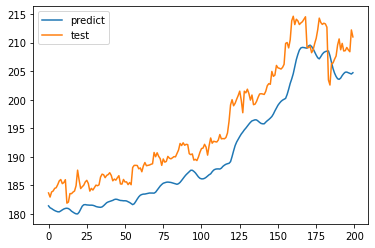

In [ ]:
plt.plot(yScaler.inverse_transform(predict[:200].reshape(-1,1)), label='predict')
plt.plot(yScaler.inverse_transform(yTest[:200].reshape(-1,1)), label='test')
plt.legend()
plt.show()

In [ ]:
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

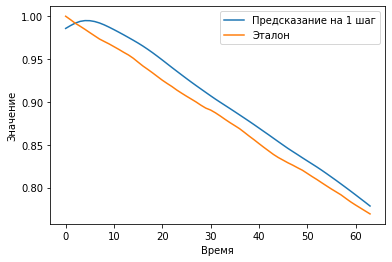

In [ ]:
showCorr([0], 64, predict, yTest)